<a href="https://colab.research.google.com/github/KatBCN/ML-PropertyAssessment/blob/main/ML_Modeling_LinearRegression2_PropertyAssessment_Buffalo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression

This notebook contains models for OLS , Lasso, Ridge, and Huber Linear Regression models, using three different sets of features.

In [1]:
# import libraries
from google.colab import drive 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import power_transform
#from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from scipy import stats
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

# set seed
np.random.seed(42)

# set options
pd.set_option('display.max_columns', None) 
sns.set()

# mount drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/ML/ML-Project/data/
%ls 

Mounted at /content/drive/
/content/drive/MyDrive/ML/ML-Project/data
imputed/  initial_splits/  metadata/  preprocessed/  results/  source_data/


This notebook uses data from the preprocessed data folder.

In [2]:
# load train data
df = pd.read_pickle("/content/drive/MyDrive/ML/ML-Project/data/imputed/train_BuffaloProperty.pkl")

val_df = pd.read_pickle("/content/drive/MyDrive/ML/ML-Project/data/imputed/validation_BuffaloProperty.pkl")


- Data from the Imputed folder:
  - The training data set has 35,921 rows and 21 columns.
  - The validation data set has 12,020 rows and 21 columns

In [3]:
print(df.shape)
print(val_df.shape)

(35921, 21)
(12020, 21)


In [4]:
print(df.dtypes)
print(val_df.dtypes)

Front                          float64
Depth                          float64
Sale Price                     float64
Year Built                     float64
Total Living Area              float64
# of Fireplaces                  int64
# of Beds                        int64
Latitude                       float64
Longitude                      float64
TotalBaths                       int64
Property Class Description    category
Overall Condition             category
Building Style                category
Heat Type                     category
Basement Type                 category
Neighborhood                  category
SameOwnerLastName             category
OwnershipType                 category
PropertyClassReformed         category
Sale Type                       object
Total Value                    float64
dtype: object
Front                          float64
Depth                          float64
Sale Price                     float64
Year Built                     float64
Total Livin

There are no missing values in this data, because it has been pre-processed with outlier detection and imputation.

In [5]:
print("Count of null values per column:")
print(df.isna().sum())

Count of null values per column:
Front                         0
Depth                         0
Sale Price                    0
Year Built                    0
Total Living Area             0
# of Fireplaces               0
# of Beds                     0
Latitude                      0
Longitude                     0
TotalBaths                    0
Property Class Description    0
Overall Condition             0
Building Style                0
Heat Type                     0
Basement Type                 0
Neighborhood                  0
SameOwnerLastName             0
OwnershipType                 0
PropertyClassReformed         0
Sale Type                     0
Total Value                   0
dtype: int64


Sale Price may not be a very reliable variable to use. The imputation allowed a nonrealistic value to appear which is negative. The imputer should be checked to make sure 0 is the minimum imputation value.

We still have Front and Total Living Area minimum values of 1, which I thought would be outliers...

In [6]:
df.describe(include='all')

,Front,Depth,Sale Price,Year Built,Total Living Area,# of Fireplaces,# of Beds,Latitude,Longitude,TotalBaths,Property Class Description,Overall Condition,Building Style,Heat Type,Basement Type,Neighborhood,SameOwnerLastName,OwnershipType,PropertyClassReformed,Sale Type,Total Value
count,35921.000000,35921.000000,35921.000000,35921.000000,35921.000000,35921.000000,35921.000000,35921.000000,35921.000000,35921.000000,35921,35921,35921,35921,35921,35921,35921,35921,35921,35921,35921.00000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,5,18,4,4,36,2,3,2,2,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ONE FAMILY DWELLING,3,08,2,4,South Park,Different name,Person,No reform,Real Sale,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20969,32307,30855,29811,27644,2863,27225,32436,35751,21439,NaN
mean,36.008568,118.405144,65726.273247,1919.137218,1816.461696,0.137691,4.054481,42.910772,-78.622463,1.692464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62981.46104
std,8.918574,23.124106,60495.573411,24.527781,615.423821,0.405385,1.303909,0.034926,4.154282,0.611045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52493.43274
min,5.000000,17.000000,0.000000,1800.000000,401.000000,0.000000,0.000000,42.832090,-78.908661,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.00000
25%,30.000000,105.000000,26000.000000,1900.000000,1325.000000,0.000000,3.000000,42.890035,-78.864922,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32000.00000
50%,33.000000,115.000000,49000.000000,1920.000000,1708.000000,0.000000,4.000000,42.917171,-78.834920,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48900.00000
75%,40.000000,130.000000,84000.000000,1927.000000,2244.000000,0.000000,5.000000,42.940270,-78.814865,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74000.00000


In [7]:
df["Age"] = 2020 - df["Year Built"]
val_df["Age"] = 2020 - val_df["Year Built"]

## Data exploration
Exploring percentages of categorical data present in the data.

In [8]:
df['Property Class Description'].value_counts(normalize=True)

ONE FAMILY DWELLING    0.583753
TWO FAMILY DWELLING    0.416247
Name: Property Class Description, dtype: float64

Confirming the validation set contains similar proportions of property classes:

In [9]:
val_df['Property Class Description'].value_counts(normalize=True)

ONE FAMILY DWELLING    0.585025
TWO FAMILY DWELLING    0.414975
Name: Property Class Description, dtype: float64

In [10]:
df['OwnershipType'].value_counts(normalize=True)

Person         0.902982
Corporation    0.094318
Buffalo        0.002700
Name: OwnershipType, dtype: float64

In [11]:
df['Heat Type'].value_counts(normalize=True)

2    0.829905
3    0.115754
1    0.052810
4    0.001531
Name: Heat Type, dtype: float64

In [12]:
df['Basement Type'].value_counts(normalize=True)

4    0.769578
3    0.133766
2    0.051363
1    0.045294
Name: Basement Type, dtype: float64

In [13]:
df['Overall Condition'].value_counts(normalize=True)

3    0.899390
2    0.052810
4    0.039865
1    0.007684
5    0.000251
Name: Overall Condition, dtype: float64

In [14]:
df['Building Style'].value_counts(normalize=True)

08    0.858968
04    0.058684
05    0.033769
01    0.025361
15    0.007322
14    0.004176
12    0.003981
10    0.001782
13    0.001754
02    0.001475
03    0.001114
09    0.000752
06    0.000334
8     0.000195
5     0.000167
1     0.000084
17    0.000056
07    0.000028
Name: Building Style, dtype: float64

I will create a new column called "Age" which is the year 2020 - Year Built

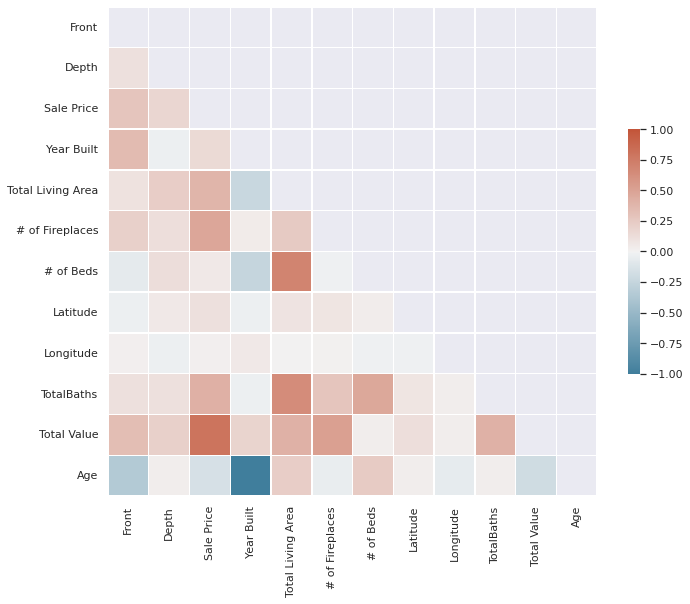

In [15]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin= -1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

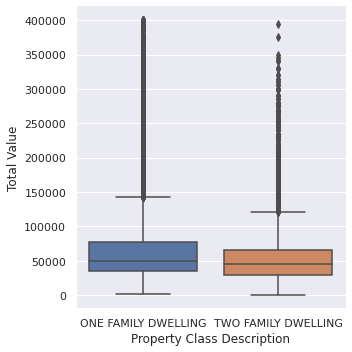

In [16]:
sns.catplot(x="Property Class Description", y="Total Value", kind="box", data=df)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]), <a list of 36 Text major ticklabel objects>)

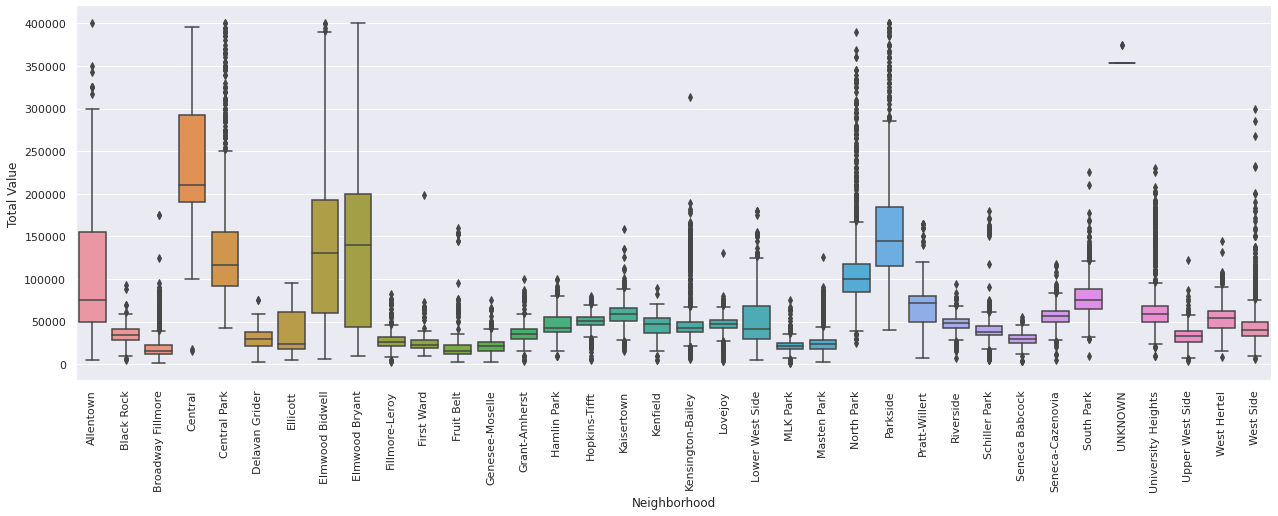

In [17]:

sns.catplot(x="Neighborhood", y="Total Value", kind="box", data=df, height=6, aspect=3)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text major ticklabel objects>)

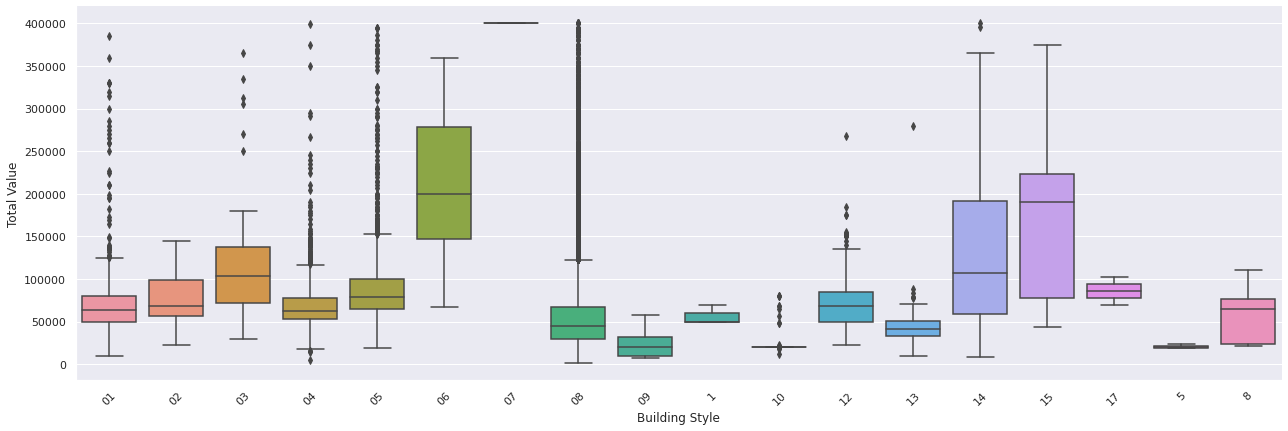

In [18]:
sns.catplot(x="Building Style", y="Total Value", kind="box", data=df, height=6, aspect=3)
plt.xticks(rotation=45)

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

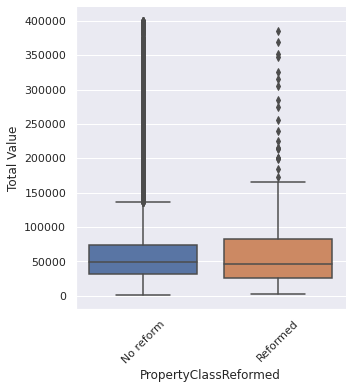

In [19]:
sns.catplot(x="PropertyClassReformed", y="Total Value", kind="box", data=df)
plt.xticks(rotation=45)

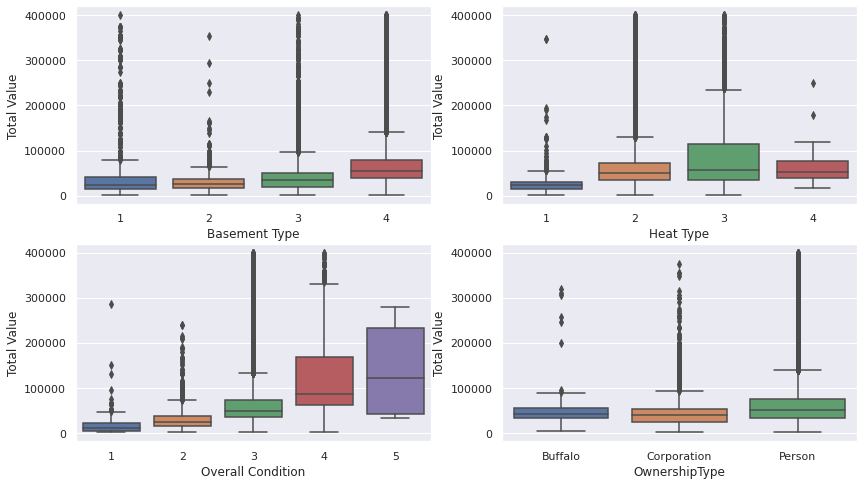

In [20]:
#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize = (14,8))

#create boxplot in each subplot
sns.boxplot(data=df, x='Basement Type', y='Total Value', ax=axes[0,0])
sns.boxplot(data=df, x='Heat Type', y='Total Value', ax=axes[0,1])
sns.boxplot(data=df, x='Overall Condition', y='Total Value', ax=axes[1,0])
sns.boxplot(data=df, x='OwnershipType', y='Total Value', ax=axes[1,1])

(array([-50000.,      0.,  50000., 100000., 150000., 200000., 250000.,
        300000., 350000., 400000., 450000.]),
 <a list of 11 Text major ticklabel objects>)

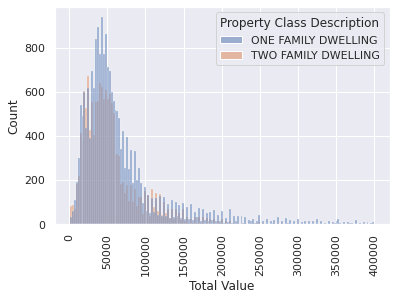

In [21]:
sns.histplot(data=df, x='Total Value', hue = "Property Class Description")
plt.xticks(rotation=90)

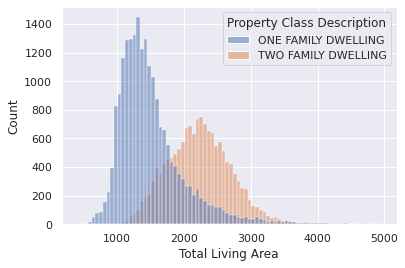

In [22]:
sns.histplot(data=df, x='Total Living Area', hue="Property Class Description")

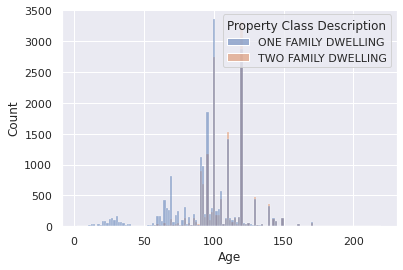

In [23]:
sns.histplot(data=df, x='Age', hue="Property Class Description")

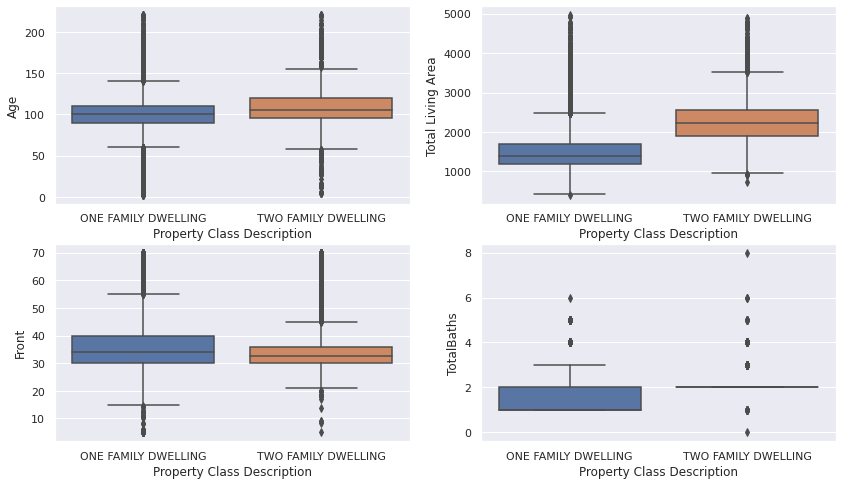

In [24]:
#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize = (14,8))

#create boxplot in each subplot
sns.boxplot(data=df, x='Property Class Description', y='Age', ax=axes[0,0])
sns.boxplot(data=df, x='Property Class Description', y='Total Living Area', ax=axes[0,1])
sns.boxplot(data=df, x='Property Class Description', y='Front', ax=axes[1,0])
sns.boxplot(data=df, x='Property Class Description', y='TotalBaths', ax=axes[1,1])

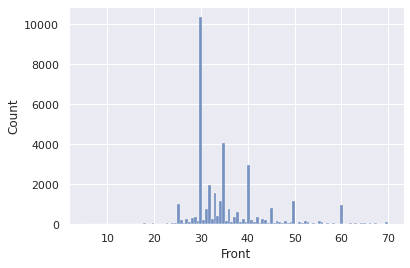

In [25]:
sns.histplot(data=df, x='Front')

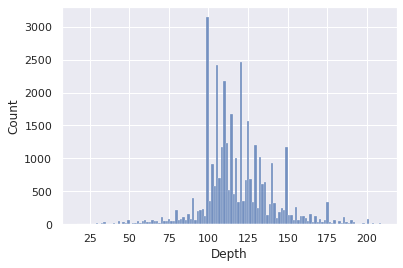

In [26]:
sns.histplot(data=df, x='Depth')

In [27]:
#sns.histplot(data=df, x='Latitude', hue="Property Class Description")

In [28]:
#sns.histplot(data=df, x='Longitude', hue="Property Class Description")

Sale Price may not be the most reliable variable since it was imputed.

(array([-50000.,      0.,  50000., 100000., 150000., 200000., 250000.,
        300000., 350000., 400000., 450000.]),
 <a list of 11 Text major ticklabel objects>)

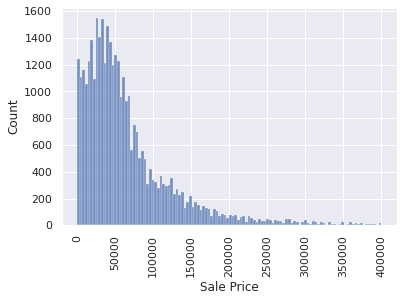

In [29]:
sns.histplot(data=df, x='Sale Price')
plt.xticks(rotation=90)

* [sklearn.preprocessing.PowerTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html)
* [sklearn.pipeline.Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline)
* [How to Transform Target Variables for Regression in Python](https://machinelearningmastery.com/how-to-transform-target-variables-for-regression-with-scikit-learn/)

## Functions for running Regression Models

Regression Metrics:
- MSE: Mean squared error, closer to 0 is better. Our target is a large value, so this is expected to be large.
- RMSE: Square root of the mean square error which is expressed in units of the target. Closer to 0 is better.
- MAE: Mean Absolute Error
- Median Absolute Error is more robust to outliers.
- R2 score / Coefficient of Determination: the amount of variance explained by the model, and a goodness of fit. Closer to 1 is better.

Reference:
[Sklearn Regression Metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)

In [30]:
results_metrics = ["Model", "Features", "MSE", "RMSE", "Mean Abs. Error", "Median Abs. Error", "R2 Score", "Train Time", "Test Partition"]
results_df = pd.DataFrame(columns = results_metrics)

In [31]:
def getRegressionMetrics (target, prediction, results_df, model, features, train_time, test_partition):
  """
  Provide a vector of the target, a vector of the prediction, the dataframe
  where results are saved, a string name for the model, and the list of features used.
  This function prints the regression metrics associated with the data, and
  returns the results dataframe with a new row appended.
  """
  MSE = np.round(mean_squared_error(target, prediction),2)
  RMSE = np.round(np.sqrt(mean_squared_error(target, prediction)),2)
  MAE = np.round((mean_absolute_error(target, prediction)),2)
  MedAE = np.round((median_absolute_error(target, prediction)),2)
  R2 = np.round(r2_score(target, prediction),2)

  # The mean squared error: units not meaningful, but smaller is better
  print("Mean squared error: %.2f" % MSE)
  # The root mean squared error: expressed in units of target
  print("Root Mean squared error: %.2f" % RMSE)
  # The mean absolute error
  print("Mean absolute error: %.2f" % MAE)
  # The median absolute error: more robust to outliers
  print("Median absolute error: %.2f" % MedAE)
  # The coefficient of determination: 1 is perfect prediction
  print("Coefficient of determination: %.2f" % R2)

  results_df = results_df.append({'Model':model, 'Features':features, 
                                  'MSE':MSE, 'RMSE':RMSE, "Mean Abs. Error":MAE,
                                  "Median Abs. Error":MedAE, "R2 Score":R2,
                                  "Train Time": train_time,
                                  "Test Partition": test_partition},
                                  ignore_index=True)
  
  print()
  print('Sample of 10 predictions vs. target:')
  print('Predicted values: ', np.round(prediction)[:10])
  print('Target values: ' ,target[:10])

  return results_df

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
def getPredictionPlot (target, prediction, title):
  """
  Provided a vector of the target and a vector of the prediction, this
  function produces a scatter plot and regression line. The title is a string
  which is expected to be the name of the model.
  """
  # Create a figure for 2 subplots (1 row, 2 columns)
  fig, ax = plt.subplots(1, 2, figsize = (14,6))

  # Create first subplot
  ax[0].scatter(target, prediction, alpha=0.25)
  ax[0].set_xlabel('Target Values')
  ax[0].set_ylabel('Predicted Values')
  ax[0].set_title('Total Value Predictions')
  # overlay the regression line
  z = np.polyfit(target, prediction, 1)
  p = np.poly1d(z)
  ax[0].plot(target,p(target), color='magenta')
  ax[0].tick_params('x', labelrotation=90)


  #Create second subplot
  # define residuals
  residuals = target - prediction
  # Fit a normal distribution to the residuals:
  mu, std = norm.fit(residuals)
  # plot residuals
  ax[1].hist(residuals, bins=50, density=True)
  # Plot the PDF.
  xmin, xmax = ax[1].get_xlim()
  x = np.linspace(xmin, xmax, 100)
  p = norm.pdf(x, mu, std)
  ax[1].plot(x, p, 'k', linewidth=2, color='magenta', label="mu:{:.2f}, std:{:.2f}".format(mu, std))
  ax[1].legend(loc="upper right")
  ax[1].set_title ("Residuals Histogram with Normal Curve")
  ax[1].set_xlabel('Residuals')
  ax[1].set_ylabel('Density')
  ax[1].tick_params('x', labelrotation=90)


  fig.suptitle(title)
  # Show the figure
  fig.show()

In [33]:
def fitLRModelPipeline(LRmodel, training_df, regression_cols):
  """
  Provide an object that is an sklearn linear regression model to train,
  the dataframe of training data, and a list of columns to use in regression.
  Returns: pipeline object that can be used to make predictions, and the
  matrices train_x and train_y.
  """
  train_x = df[regression_cols]
  train_y = df["Total Value"]

  # define numeric and categorical features
  numeric_features = train_x.select_dtypes(include=np.number).columns.tolist()
  object_columns = train_x.select_dtypes(include='object').columns.tolist()
  # convert object type columns to category type
  for col in object_columns:
    train_x[col] = train_x[col].astype("category")
  categorical_features = train_x.select_dtypes(include='category').columns.tolist()

  categorical_transformer = OneHotEncoder(handle_unknown="ignore")

  # numeric features are not processed
  # categorical features are one hot encoded
  preprocessor = ColumnTransformer(
      transformers=[                   
          ("cat", categorical_transformer, categorical_features)
      ], remainder='passthrough' # remainder='passthrough' is required to include numeric features.
  )
  # define the pipeline
  pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                            ('model', LRmodel)])

  #track time to train model
  start_time = time.time()

  # fit pipeline
  pipeline.fit(train_x, train_y)
  train_time = time.time() - start_time
  print (pipeline.named_steps['model'], "training time:", train_time)

  # get weights of model
  weights = pipeline.named_steps['model'].coef_

  # get intercept of model
  intercept = pipeline.named_steps['model'].intercept_

  # Access some info about the model.
  print('Coefficients: \n', weights)
  print('Intercept: \n', intercept)
  
  return pipeline, train_x, train_y, train_time


## Ordinary least squares Linear Regression

We start by defining a regression model with training features that include some numeric variables and the property class description to distinguish between one family and two family dwellings. 

In [34]:
# define the model
LRmodel = LinearRegression()
# define the data that will be used in the model
regression_cols = ["Property Class Description", "Front", "Age",
                   "Total Living Area", "# of Fireplaces", 
                   "# of Beds", "TotalBaths"]
# save and fit the pipeline
OLSpipeline, train_x, train_y, train_time = fitLRModelPipeline(LRmodel, df, regression_cols)

LinearRegression() training time: 0.05419206619262695
Coefficients: 
 [ 20003.49082449 -20003.49082449    464.91507542   -353.57091855
     47.79656092  30758.76856449  -7125.78072285  21611.93198361]
Intercept: 
 -20189.938676226666


In [35]:
# separate target from features in validation set
val_x = val_df[regression_cols]
val_y = val_df["Total Value"]

# save predictions from data
y_pred_train = OLSpipeline.predict(train_x)
y_pred_validation = OLSpipeline.predict(val_x)

# update the results and evaluate performance of predictions on target
results_df = getRegressionMetrics(train_y, y_pred_train, results_df, "OLS", regression_cols, train_time, "Train")
results_df = getRegressionMetrics(val_y, y_pred_validation, results_df, "OLS", regression_cols, train_time, "Validation") 

Mean squared error: 1229771462.34
Root Mean squared error: 35068.10
Mean absolute error: 24645.21
Median absolute error: 17785.11
Coefficient of determination: 0.55

Sample of 10 predictions vs. target:
Predicted values:  [ 97085.  82496.  49978. 104635.  90127.  31922.  27218. 129154.  55443.
  60522.]
Target values:  SBL
1003800004027000    175000.0
0907200002032000     10000.0
0896700003003000     33800.0
0797100006030000     51100.0
1334800003004000     75000.0
0887400003012000     35500.0
1016900005054111     25000.0
0788400002006000    295000.0
0907900002024000     25000.0
0887400003019000     35000.0
Name: Total Value, dtype: float64
Mean squared error: 1182015378.63
Root Mean squared error: 34380.45
Mean absolute error: 24239.62
Median absolute error: 17169.03
Coefficient of determination: 0.56

Sample of 10 predictions vs. target:
Predicted values:  [ 51263.  20946.  71294.  69036.  32658.  51265.  95519. 108076. 106013.
  31126.]
Target values:  SBL
1334600001006000        65

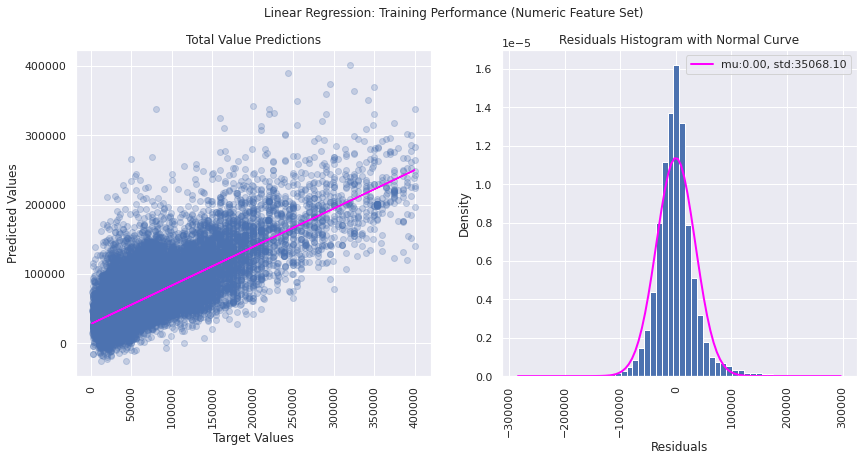

In [36]:
# create visualizations to evaluate performance
getPredictionPlot(train_y, y_pred_train, "Linear Regression: Training Performance (Numeric Feature Set)")

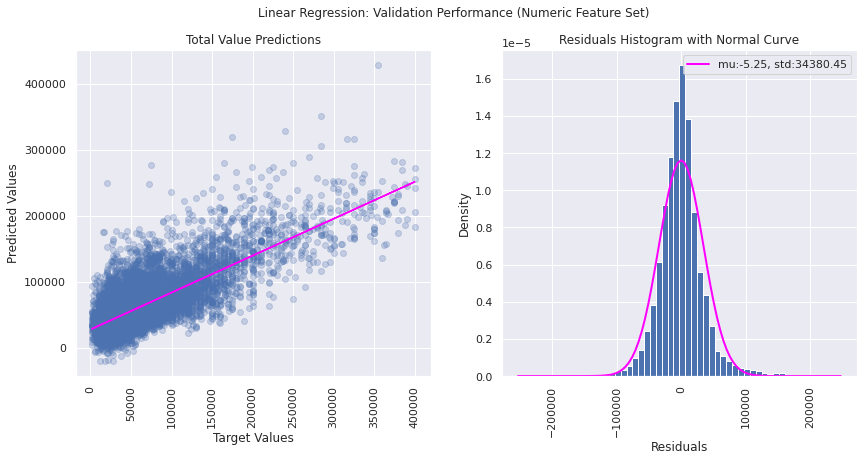

In [37]:
# create visualizations to evaluate performance
getPredictionPlot(val_y, y_pred_validation, "Linear Regression: Validation Performance (Numeric Feature Set)")

Now we expand the regression features to include the Neighborhood.

In [38]:
# define the model
LRmodel = LinearRegression()
# define the data that will be used in the model
regression_cols = ["Property Class Description", "Neighborhood", "Front", "Age",
                   "Total Living Area", "# of Fireplaces", "# of Beds", 
                   "TotalBaths"]
# save and fit the pipeline
OLSpipeline, train_x, train_y, train_time = fitLRModelPipeline(LRmodel, df, regression_cols)

LinearRegression() training time: 0.21106934547424316
Coefficients: 
 [ 1.52123109e+04 -1.52123109e+04  2.17981987e+04 -2.11693379e+04
 -3.57175260e+04  1.08695077e+05  3.86752382e+04 -2.72949718e+04
 -2.95911902e+04  4.68549466e+04  4.19183353e+04 -3.09266761e+04
 -2.84800212e+04 -3.64270751e+04 -3.20257279e+04 -1.52699185e+04
 -2.61310651e+04 -9.60932641e+03  1.03743147e+02 -1.46715097e+04
 -1.27384417e+04 -1.13441850e+04 -1.24832657e+04 -3.53664759e+04
 -3.96335785e+04  3.11432618e+04  5.28125673e+04 -2.91964269e+04
 -7.37877708e+03 -1.62081132e+04 -2.38386898e+04 -7.08590792e+03
  9.91298575e+03  1.97479130e+05 -2.79541832e+03 -2.16428413e+04
 -5.56775668e+03 -1.67992596e+04  5.24219711e+02 -2.21989493e+02
  3.03079003e+01  1.89693950e+04 -3.56801880e+03  1.70800452e+04]
Intercept: 
 -4026.370336277454


In [39]:
# save predictions from data
val_x = val_df[regression_cols]
val_y = val_df["Total Value"]


y_pred_train = OLSpipeline.predict(train_x)
y_pred_validation = OLSpipeline.predict(val_x)

# update the results and evaluate performance of predictions on target
results_df = getRegressionMetrics(train_y, y_pred_train, results_df, "OLS", regression_cols, train_time, "Train")
results_df = getRegressionMetrics(val_y, y_pred_validation, results_df, "OLS", regression_cols, train_time, "Validation") 

Mean squared error: 664234129.76
Root Mean squared error: 25772.74
Mean absolute error: 16065.81
Median absolute error: 10006.15
Coefficient of determination: 0.76

Sample of 10 predictions vs. target:
Predicted values:  [126460.  68502.  32558. 101648.  93046.  26129.   7846. 149272.  28948.
  45762.]
Target values:  SBL
1003800004027000    175000.0
0907200002032000     10000.0
0896700003003000     33800.0
0797100006030000     51100.0
1334800003004000     75000.0
0887400003012000     35500.0
1016900005054111     25000.0
0788400002006000    295000.0
0907900002024000     25000.0
0887400003019000     35000.0
Name: Total Value, dtype: float64
Mean squared error: 634407736.60
Root Mean squared error: 25187.45
Mean absolute error: 15808.76
Median absolute error: 9991.01
Coefficient of determination: 0.76

Sample of 10 predictions vs. target:
Predicted values:  [ 52042.   1476.  84541. 173639.  10963.  34324.  56314.  67758.  78509.
  23867.]
Target values:  SBL
1334600001006000        65000

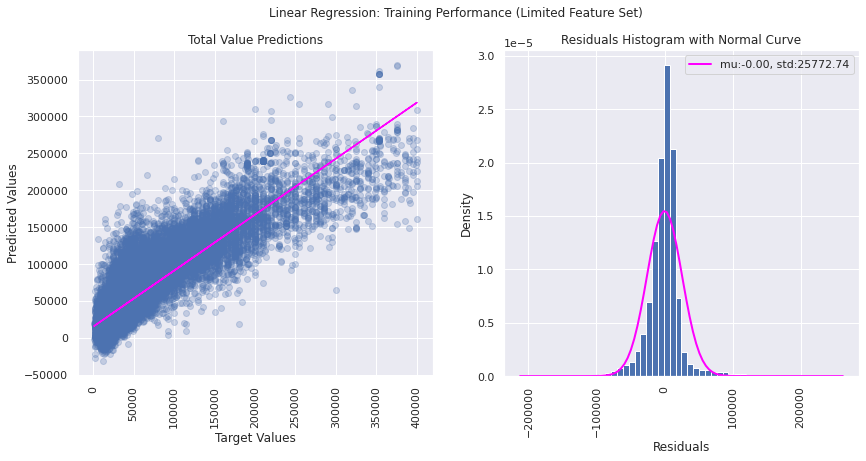

In [40]:
# create visualizations to evaluate performance
getPredictionPlot(train_y, y_pred_train, "Linear Regression: Training Performance (Limited Feature Set)")

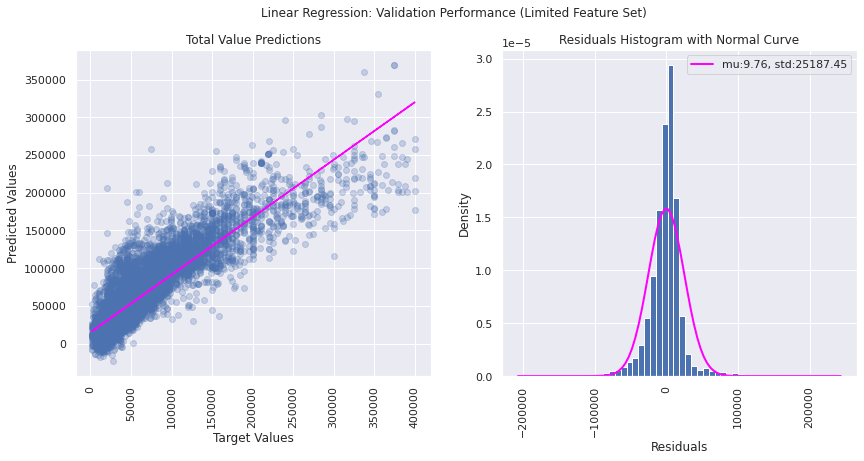

In [41]:
# create visualizations to evaluate performance
getPredictionPlot(val_y, y_pred_validation, "Linear Regression: Validation Performance (Limited Feature Set)")

I will re-run the model adding more categorical variables including Overall Condition, Building Style, and Heat Type.


In [42]:
# define the model
LRmodel = LinearRegression()
# define the data that will be used in the model
regression_cols = ["Property Class Description", "Neighborhood", "Front", "Age",
                   "Total Living Area", "# of Fireplaces", "# of Beds", 
                   "TotalBaths", "Overall Condition", "Building Style", 
                   "Heat Type"]
# save and fit the pipeline
OLSpipeline, train_x, train_y, train_time = fitLRModelPipeline(LRmodel, df, regression_cols)

LinearRegression() training time: 0.4608266353607178
Coefficients: 
 [ 1.45420332e+04 -1.45420332e+04  1.90857634e+04 -2.01409606e+04
 -3.40438445e+04  9.27395737e+04  4.06071577e+04 -2.55620892e+04
 -2.96465805e+04  4.71154981e+04  4.11649587e+04 -2.90564886e+04
 -2.75840956e+04 -3.50981003e+04 -2.95705110e+04 -1.48453881e+04
 -2.44645916e+04 -7.24464765e+03  1.97214974e+03 -1.23056214e+04
 -1.05469649e+04 -9.81210334e+03 -1.29059684e+04 -3.37362574e+04
 -3.85099772e+04  3.28063435e+04  5.41027459e+04 -3.16497152e+04
 -5.44604703e+03 -1.41500708e+04 -2.33121748e+04 -5.85580008e+03
  1.16276140e+04  1.77032808e+05 -6.63783731e+02 -2.10698341e+04
 -4.69618519e+03 -1.63368113e+04 -1.28919112e+04 -8.62975175e+03
 -6.13640700e+02  1.16346992e+04  1.05006045e+04 -3.81211435e+02
 -2.70862239e+03  4.15286139e+03 -5.39644837e+03  1.60925199e+03
  3.36013644e+04  1.24670007e+05 -3.71598103e+03 -1.40298892e+04
 -1.21494181e+04  4.47354295e+02 -1.82469575e+03 -2.27856535e+02
  1.75836975e+04  1.3

In [43]:
# save predictions from data
val_x = val_df[regression_cols]
val_y = val_df["Total Value"]


y_pred_train = OLSpipeline.predict(train_x)
y_pred_validation = OLSpipeline.predict(val_x)

# update the results and evaluate performance of predictions on target
results_df = getRegressionMetrics(train_y, y_pred_train, results_df, "OLS", regression_cols, train_time, "Train")
results_df = getRegressionMetrics(val_y, y_pred_validation, results_df, "OLS", regression_cols, train_time, "Validation") 

Mean squared error: 649209939.49
Root Mean squared error: 25479.60
Mean absolute error: 15852.44
Median absolute error: 9879.76
Coefficient of determination: 0.76

Sample of 10 predictions vs. target:
Predicted values:  [124028.  60264.  34051. 102873.  92528.  26829.  10735. 150974.  30300.
  45350.]
Target values:  SBL
1003800004027000    175000.0
0907200002032000     10000.0
0896700003003000     33800.0
0797100006030000     51100.0
1334800003004000     75000.0
0887400003012000     35500.0
1016900005054111     25000.0
0788400002006000    295000.0
0907900002024000     25000.0
0887400003019000     35000.0
Name: Total Value, dtype: float64
Mean squared error: 622023925.37
Root Mean squared error: 24940.41
Mean absolute error: 15621.75
Median absolute error: 9861.52
Coefficient of determination: 0.77

Sample of 10 predictions vs. target:
Predicted values:  [ 54018.   -579.  83439. 171710.  14742.  35981.  55905.  67022.  70778.
  27941.]
Target values:  SBL
1334600001006000        65000.

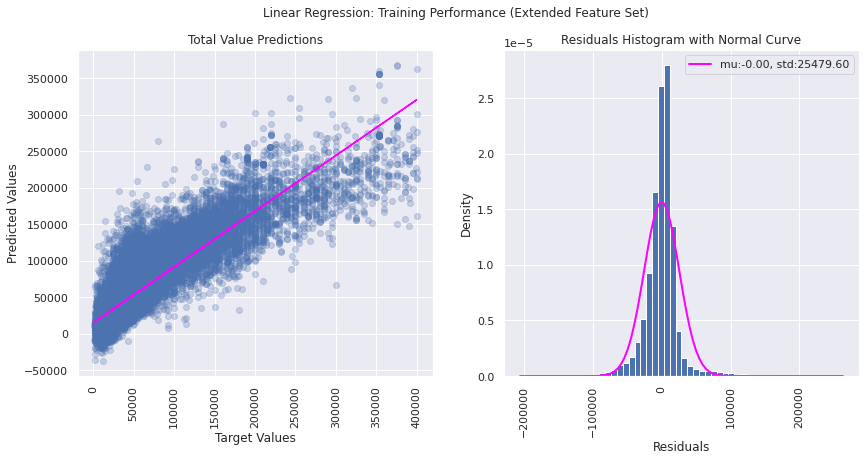

In [44]:
# create visualizations to evaluate performance
getPredictionPlot(train_y, y_pred_train, "Linear Regression: Training Performance (Extended Feature Set)")

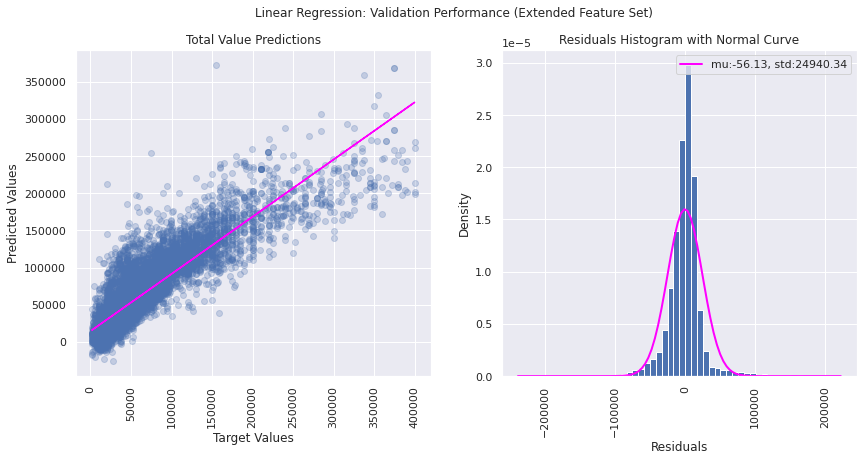

In [45]:
# create visualizations to evaluate performance
getPredictionPlot(val_y, y_pred_validation, "Linear Regression: Validation Performance (Extended Feature Set)")

I will re-run the model using only numerical variables that were included in the previous models and the property class description categorical feature.

## Linear Model trained with L1 prior as regularizer (aka the Lasso)

Starting with the same numerical features and property class description as the previous model.

In [46]:
# define the model
LRmodel = Lasso()
# define the data that will be used in the model
regression_cols = ["Property Class Description", "Front", "Age",
                   "Total Living Area", "# of Fireplaces", 
                   "# of Beds", "TotalBaths"]
# save and fit the pipeline
LassoPipeline, train_x, train_y, train_time = fitLRModelPipeline(LRmodel, df, regression_cols)

Lasso() training time: 0.037690162658691406
Coefficients: 
 [ 3.99994464e+04 -5.33508748e-13  4.65001218e+02 -3.53594387e+02
  4.77981195e+01  3.07551131e+04 -7.12624523e+03  2.16062014e+04]
Intercept: 
 -40180.51120344461


In [47]:
# save predictions from data
val_x = val_df[regression_cols]
val_y = val_df["Total Value"]


y_pred_train = LassoPipeline.predict(train_x)
y_pred_validation = LassoPipeline.predict(val_x)

# update the results and evaluate performance of predictions on target
results_df = getRegressionMetrics(train_y, y_pred_train, results_df, "Lasso", regression_cols, train_time, "Train")
results_df = getRegressionMetrics(val_y, y_pred_validation, results_df, "Lasso", regression_cols, train_time, "Validation") 

Mean squared error: 1229771478.69
Root Mean squared error: 35068.10
Mean absolute error: 24645.03
Median absolute error: 17782.10
Coefficient of determination: 0.55

Sample of 10 predictions vs. target:
Predicted values:  [ 97082.  82491.  49981. 104634.  90130.  31921.  27220. 129154.  55445.
  60516.]
Target values:  SBL
1003800004027000    175000.0
0907200002032000     10000.0
0896700003003000     33800.0
0797100006030000     51100.0
1334800003004000     75000.0
0887400003012000     35500.0
1016900005054111     25000.0
0788400002006000    295000.0
0907900002024000     25000.0
0887400003019000     35000.0
Name: Total Value, dtype: float64
Mean squared error: 1182017335.48
Root Mean squared error: 34380.48
Mean absolute error: 24239.41
Median absolute error: 17171.25
Coefficient of determination: 0.56

Sample of 10 predictions vs. target:
Predicted values:  [ 51266.  20945.  71289.  69030.  32660.  51267.  95517. 108076. 106018.
  31125.]
Target values:  SBL
1334600001006000        65

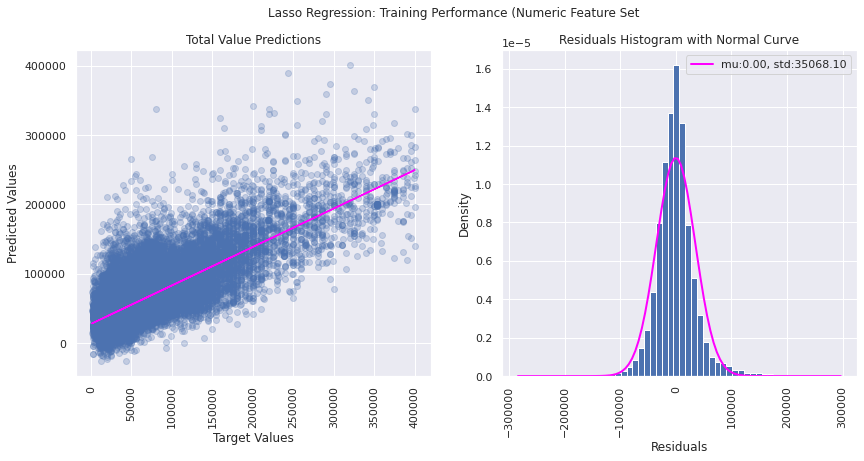

In [48]:
# create visualizations to evaluate performance
getPredictionPlot(train_y, y_pred_train, "Lasso Regression: Training Performance (Numeric Feature Set")

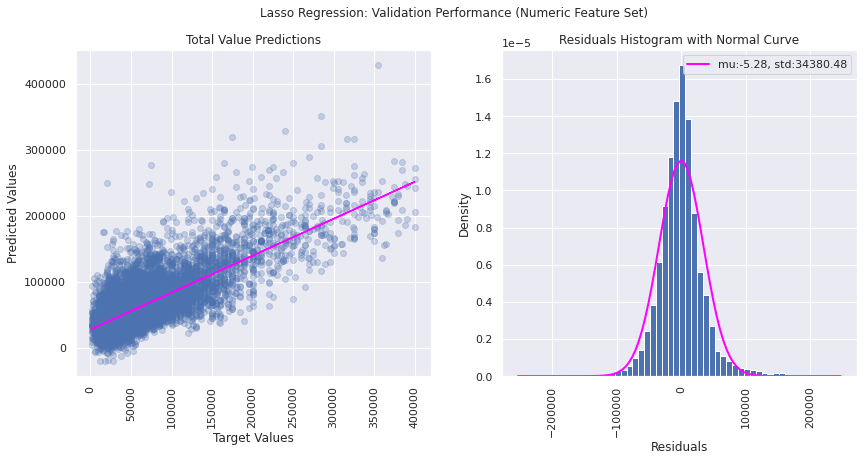

In [49]:
# create visualizations to evaluate performance
getPredictionPlot(val_y, y_pred_validation, "Lasso Regression: Validation Performance (Numeric Feature Set)")

Adding Neighborhood

In [50]:
# define the model
LRmodel = Lasso()
# define the data that will be used in the model
regression_cols = ["Property Class Description", "Neighborhood", "Front", "Age",
                   "Total Living Area", "# of Fireplaces", "# of Beds", 
                   "TotalBaths"]
# save and fit the pipeline
LassoPipeline, train_x, train_y, train_time = fitLRModelPipeline(LRmodel, df, regression_cols)

Lasso() training time: 5.776232481002808
Coefficients: 
 [ 3.04306161e+04 -3.57635001e-06  3.44543162e+04 -8.32627060e+03
 -2.29351639e+04  1.21126688e+05  5.13715216e+04 -1.44965309e+04
 -1.66946827e+04  5.95768820e+04  5.46012650e+04 -1.81243807e+04
 -1.56193384e+04 -2.35650402e+04 -1.92395546e+04 -2.41131278e+03
 -1.33322209e+04  3.11739457e+03  1.28322643e+04 -1.88040664e+03
  0.00000000e+00  1.38962254e+03  1.50425071e+02 -2.25517863e+04
 -2.68409237e+04  4.38769989e+04  6.55146883e+04 -1.63544689e+04
  5.35749443e+03 -3.42445193e+03 -1.09760547e+04  5.64001912e+03
  2.26523096e+04  2.06138673e+05  9.92885012e+03 -8.83954666e+03
  7.10435880e+03 -4.00035568e+03  5.23584484e+02 -2.22543874e+02
  3.03286312e+01  1.89850707e+04 -3.57589169e+03  1.70905297e+04]
Intercept: 
 -31943.381279800917


In [51]:
# save predictions from data
val_x = val_df[regression_cols]
val_y = val_df["Total Value"]


y_pred_train = LassoPipeline.predict(train_x)
y_pred_validation = LassoPipeline.predict(val_x)

# update the results and evaluate performance of predictions on target
results_df = getRegressionMetrics(train_y, y_pred_train, results_df, "Lasso", regression_cols, train_time, "Train")
results_df = getRegressionMetrics(val_y, y_pred_validation, results_df, "Lasso", regression_cols, train_time, "Validation") 

Mean squared error: 664240391.04
Root Mean squared error: 25772.86
Mean absolute error: 16065.60
Median absolute error: 10008.44
Coefficient of determination: 0.76

Sample of 10 predictions vs. target:
Predicted values:  [126409.  68538.  32587. 101611.  93043.  26147.   7844. 149230.  28977.
  45798.]
Target values:  SBL
1003800004027000    175000.0
0907200002032000     10000.0
0896700003003000     33800.0
0797100006030000     51100.0
1334800003004000     75000.0
0887400003012000     35500.0
1016900005054111     25000.0
0788400002006000    295000.0
0907900002024000     25000.0
0887400003019000     35000.0
Name: Total Value, dtype: float64
Mean squared error: 634413679.97
Root Mean squared error: 25187.57
Mean absolute error: 15808.92
Median absolute error: 9990.12
Coefficient of determination: 0.76

Sample of 10 predictions vs. target:
Predicted values:  [ 52012.   1454.  84528. 173379.  11006.  34349.  56378.  67891.  78569.
  23868.]
Target values:  SBL
1334600001006000        65000

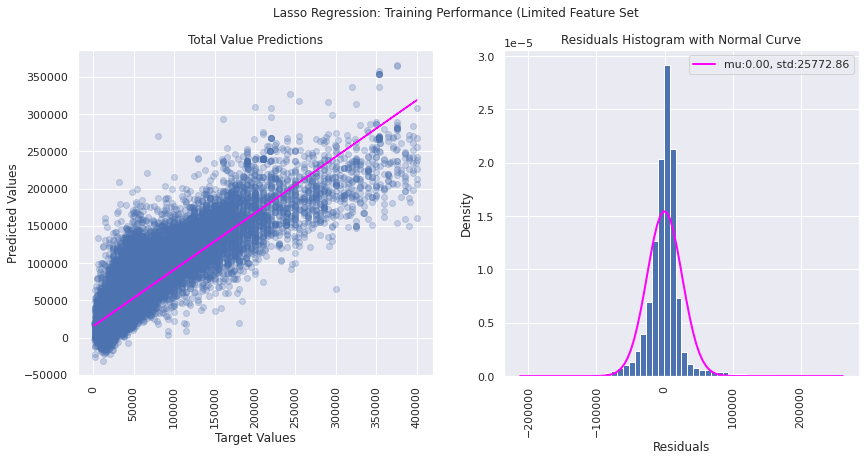

In [52]:
# create visualizations to evaluate performance
getPredictionPlot(train_y, y_pred_train, "Lasso Regression: Training Performance (Limited Feature Set")

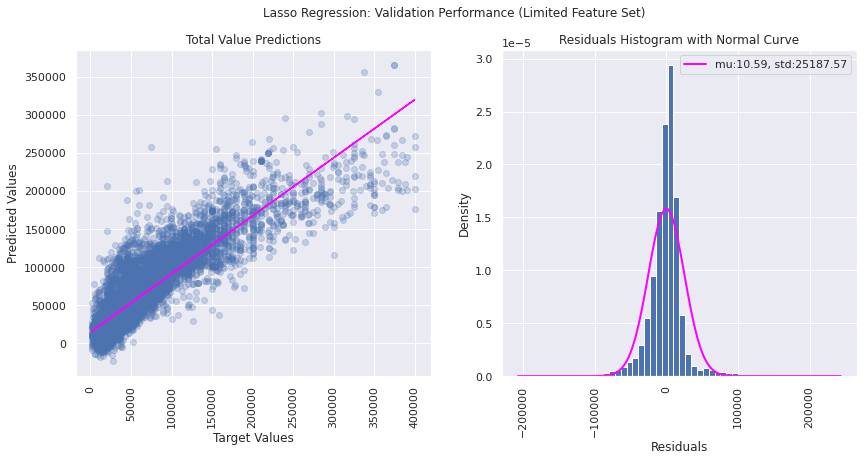

In [53]:
# create visualizations to evaluate performance
getPredictionPlot(val_y, y_pred_validation, "Lasso Regression: Validation Performance (Limited Feature Set)")

Running the model with more categorical variables.

In [54]:
# define the model
LRmodel = Lasso()
# define the data that will be used in the model
regression_cols = ["Property Class Description", "Neighborhood", "Front", "Age",
                   "Total Living Area", "# of Fireplaces", "# of Beds", 
                   "TotalBaths", "Overall Condition", "Building Style", 
                   "Heat Type"]
# save and fit the pipeline
LassoPipeline, train_x, train_y, train_time = fitLRModelPipeline(LRmodel, df, regression_cols)

Lasso() training time: 13.411409854888916
Coefficients: 
 [ 2.91339562e+04 -5.17358712e-06  3.14782127e+04 -7.81602081e+03
 -2.16933592e+04  1.05062972e+05  5.28456286e+04 -1.31942003e+04
 -1.70055791e+04  5.94331320e+04  5.34315900e+04 -1.67486560e+04
 -1.54050826e+04 -2.27740209e+04 -1.72025803e+04 -2.35259575e+03
 -1.21154698e+04  4.90869305e+03  1.42483686e+04  0.00000000e+00
  1.79971202e+03  2.56064216e+03 -3.64299668e+02 -2.13817774e+04
 -2.60675267e+04  4.51105275e+04  6.63519816e+04 -1.92968683e+04
  6.88648128e+03 -1.76043058e+03 -1.05990195e+04  6.46283660e+03
  2.39549240e+04  1.86898718e+05  1.16796950e+04 -8.68015255e+03
  7.70783422e+03 -3.99343016e+03 -1.24028180e+04 -8.00232124e+03
  0.00000000e+00  1.21766460e+04  9.53196549e+03  1.70596299e+03
 -7.89159303e+02  6.97049804e+03 -3.39909678e+03  3.58497719e+03
  3.64741367e+04  1.28686718e+05 -1.73818224e+03 -7.98277713e+03
 -0.00000000e+00  1.64952427e+03 -0.00000000e+00  0.00000000e+00
  1.90046629e+04  1.50891050e+04

In [55]:
# save predictions from data
val_x = val_df[regression_cols]
val_y = val_df["Total Value"]


y_pred_train = LassoPipeline.predict(train_x)
y_pred_validation = LassoPipeline.predict(val_x)

# update the results and evaluate performance of predictions on target
results_df = getRegressionMetrics(train_y, y_pred_train, results_df, "Lasso", regression_cols, train_time, "Train")
results_df = getRegressionMetrics(val_y, y_pred_validation, results_df, "Lasso", regression_cols, train_time, "Validation") 

Mean squared error: 649190291.61
Root Mean squared error: 25479.21
Mean absolute error: 15857.30
Median absolute error: 9876.41
Coefficient of determination: 0.76

Sample of 10 predictions vs. target:
Predicted values:  [124127.  60207.  33984. 102895.  92679.  26773.  10636. 151019.  30280.
  45410.]
Target values:  SBL
1003800004027000    175000.0
0907200002032000     10000.0
0896700003003000     33800.0
0797100006030000     51100.0
1334800003004000     75000.0
0887400003012000     35500.0
1016900005054111     25000.0
0788400002006000    295000.0
0907900002024000     25000.0
0887400003019000     35000.0
Name: Total Value, dtype: float64
Mean squared error: 621800165.82
Root Mean squared error: 24935.92
Mean absolute error: 15625.26
Median absolute error: 9844.64
Coefficient of determination: 0.77

Sample of 10 predictions vs. target:
Predicted values:  [ 53886.   -463.  83436. 171304.  14670.  35875.  55918.  66959.  70836.
  28012.]
Target values:  SBL
1334600001006000        65000.

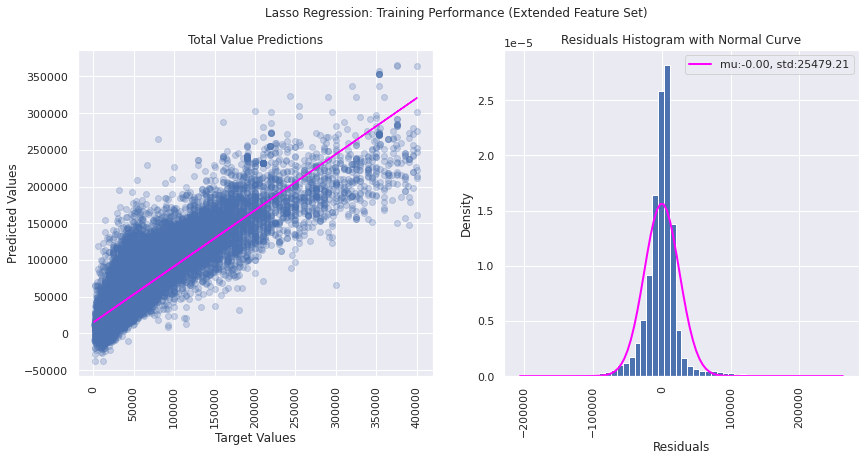

In [56]:
# create visualizations to evaluate performance
getPredictionPlot(train_y, y_pred_train, "Lasso Regression: Training Performance (Extended Feature Set)")

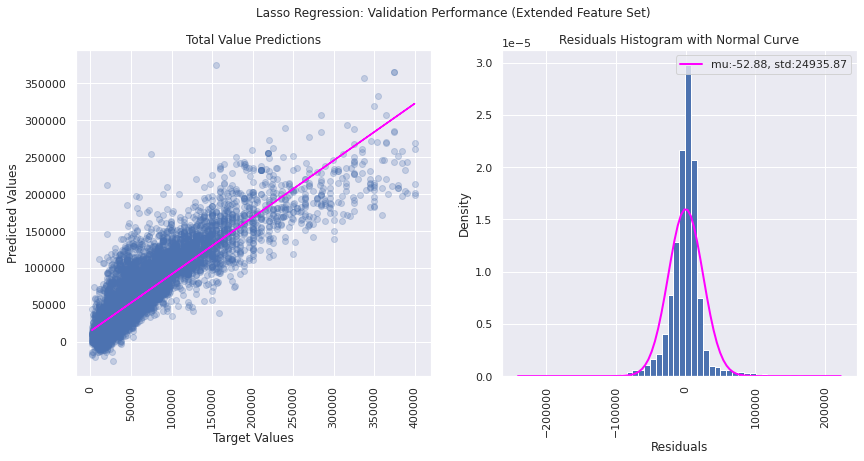

In [57]:
# create visualizations to evaluate performance
getPredictionPlot(val_y, y_pred_validation, "Lasso Regression: Validation Performance (Extended Feature Set)")

## Linear least squares with l2 regularization (aka Ridge)

Starting with same numeric features as previous model.

In [58]:
# define the model
LRmodel = Ridge()
# define the data that will be used in the model
regression_cols = ["Property Class Description", "Front", "Age",
                   "Total Living Area", "# of Fireplaces", 
                   "# of Beds", "TotalBaths"]

# save and fit the pipeline
RidgePipeline, train_x, train_y, train_time = fitLRModelPipeline(LRmodel, df, regression_cols)

Ridge() training time: 0.022536277770996094
Coefficients: 
 [ 20001.42652467 -20001.4265247     464.97732122   -353.58379918
     47.79873519  30754.23643583  -7126.70547066  21608.91632884]
Intercept: 
 -20185.007283048166


In [59]:
# save predictions from data
val_x = val_df[regression_cols]
val_y = val_df["Total Value"]


y_pred_train = RidgePipeline.predict(train_x)
y_pred_validation = RidgePipeline.predict(val_x)

# update the results and evaluate performance of predictions on target
results_df = getRegressionMetrics(train_y, y_pred_train, results_df, "Ridge", regression_cols, train_time, "Train")
results_df = getRegressionMetrics(val_y, y_pred_validation, results_df, "Ridge", regression_cols, train_time, "Validation") 

Mean squared error: 1229771470.15
Root Mean squared error: 35068.10
Mean absolute error: 24645.16
Median absolute error: 17783.47
Coefficient of determination: 0.55

Sample of 10 predictions vs. target:
Predicted values:  [ 97082.  82493.  49979. 104636.  90131.  31920.  27218. 129153.  55444.
  60518.]
Target values:  SBL
1003800004027000    175000.0
0907200002032000     10000.0
0896700003003000     33800.0
0797100006030000     51100.0
1334800003004000     75000.0
0887400003012000     35500.0
1016900005054111     25000.0
0788400002006000    295000.0
0907900002024000     25000.0
0887400003019000     35000.0
Name: Total Value, dtype: float64
Mean squared error: 1182016412.49
Root Mean squared error: 34380.47
Mean absolute error: 24239.55
Median absolute error: 17170.80
Coefficient of determination: 0.56

Sample of 10 predictions vs. target:
Predicted values:  [ 51265.  20946.  71291.  69033.  32659.  51265.  95518. 108077. 106017.
  31125.]
Target values:  SBL
1334600001006000        65

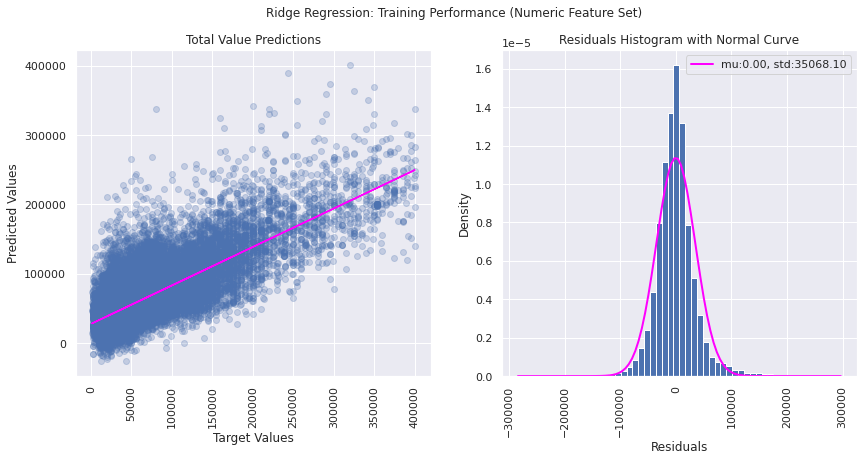

In [60]:
# create visualizations to evaluate performance
getPredictionPlot(train_y, y_pred_train, "Ridge Regression: Training Performance (Numeric Feature Set)")

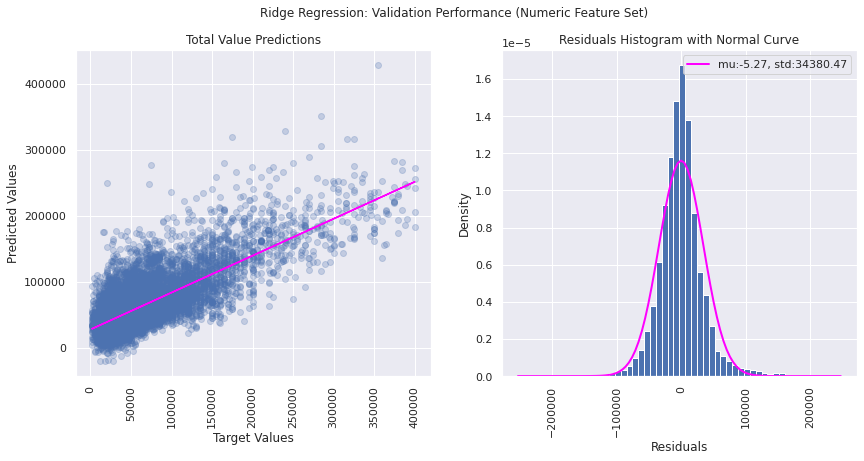

In [61]:
# create visualizations to evaluate performance
getPredictionPlot(val_y, y_pred_validation, "Ridge Regression: Validation Performance (Numeric Feature Set)")

Adding Neighborhood

In [62]:
# define the model
LRmodel = Ridge()
# define the data that will be used in the model
regression_cols = ["Property Class Description", "Neighborhood", "Front", "Age",
                   "Total Living Area", "# of Fireplaces", "# of Beds", 
                   "TotalBaths"]
# save and fit the pipeline
RidgePipeline, train_x, train_y, train_time = fitLRModelPipeline(LRmodel, df, regression_cols)

Ridge() training time: 0.06889486312866211
Coefficients: 
 [ 10179.70959075 -10179.70959075    554.64554198   -211.50656019
  -2144.3719443     865.59675223   1572.96065624   -884.64411109
   -218.94441547   3453.92557585   1531.41808651   -889.1523983
   -277.88671866   -407.30501454  -1533.30128537   -202.87221409
   -928.02264699   -402.83325758     39.98610353   -517.50414989
   -585.56131694   -385.39606428    -74.49274105   -788.33027448
  -1596.32146676   3049.78042447   2571.4489432    -342.19318369
   -219.54886008   -744.2931663    -304.49792257   -465.57157867
   1336.98252605     86.87338985    146.11730615   -525.36099773
   -126.47788335   -433.34513366    607.08182888   -402.33363313
     70.04775085  10004.19548853 -18848.52205166   4664.62509171]
Intercept: 
 19741.899884554245


In [63]:
# save predictions from data
val_x = val_df[regression_cols]
val_y = val_df["Total Value"]


y_pred_train = RidgePipeline.predict(train_x)
y_pred_validation = RidgePipeline.predict(val_x)

# update the results and evaluate performance of predictions on target
results_df = getRegressionMetrics(train_y, y_pred_train, results_df, "Ridge", regression_cols, train_time, "Train")
results_df = getRegressionMetrics(val_y, y_pred_validation, results_df, "Ridge", regression_cols, train_time, "Validation") 

Mean squared error: 1389589198.01
Root Mean squared error: 37277.19
Mean absolute error: 26039.94
Median absolute error: 18897.08
Coefficient of determination: 0.50

Sample of 10 predictions vs. target:
Predicted values:  [ 97826.  55485.  47636. 100118. 128642.  10684.  15619. 142199.  53673.
  43558.]
Target values:  SBL
1003800004027000    175000.0
0907200002032000     10000.0
0896700003003000     33800.0
0797100006030000     51100.0
1334800003004000     75000.0
0887400003012000     35500.0
1016900005054111     25000.0
0788400002006000    295000.0
0907900002024000     25000.0
0887400003019000     35000.0
Name: Total Value, dtype: float64
Mean squared error: 1350600519.92
Root Mean squared error: 36750.52
Mean absolute error: 25781.66
Median absolute error: 18851.02
Coefficient of determination: 0.50

Sample of 10 predictions vs. target:
Predicted values:  [ 56511.  36215.  57584.  64395.  22839.  41116.  88534. 107550. 126753.
  33857.]
Target values:  SBL
1334600001006000        65

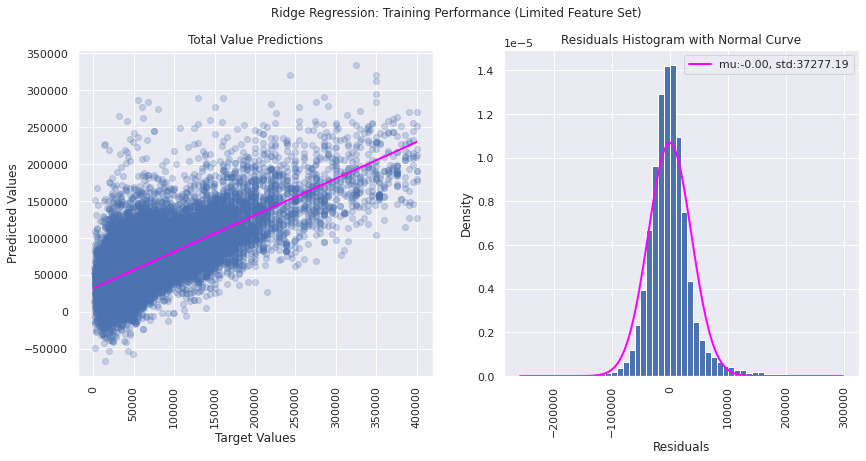

In [64]:
# create visualizations to evaluate performance
getPredictionPlot(train_y, y_pred_train, "Ridge Regression: Training Performance (Limited Feature Set)")

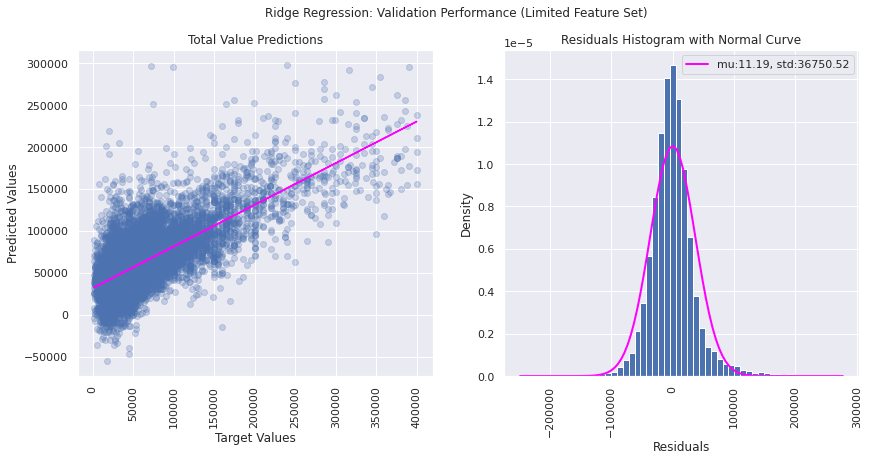

In [65]:
# create visualizations to evaluate performance
getPredictionPlot(val_y, y_pred_validation, "Ridge Regression: Validation Performance (Limited Feature Set)")

Running the model with more categorical variables.

In [66]:
# define the model
LRmodel = Ridge()
# define the data that will be used in the model
regression_cols = ["Property Class Description", "Neighborhood", "Front", "Age",
                   "Total Living Area", "# of Fireplaces", "# of Beds", 
                   "TotalBaths", "Overall Condition", "Building Style", 
                   "Heat Type"]
# save and fit the pipeline
RidgePipeline, train_x, train_y, train_time = fitLRModelPipeline(LRmodel, df, regression_cols)

Ridge() training time: 0.09310770034790039
Coefficients: 
 [ 1.01592538e+04 -1.01592538e+04  5.53469292e+02 -2.11140030e+02
 -2.14032576e+03  8.63876255e+02  1.56971938e+03 -8.82832945e+02
 -2.18545177e+02  3.44732623e+03  1.52838443e+03 -8.87406435e+02
 -2.77369219e+02 -4.06554168e+02 -1.53029391e+03 -2.02541681e+02
 -9.26188390e+02 -4.02050805e+02  3.98267568e+01 -5.16379405e+02
 -5.84131889e+02 -3.84670022e+02 -7.44283634e+01 -7.86882903e+02
 -1.59333344e+03  3.04414398e+03  2.56651780e+03 -3.41609023e+02
 -2.18953714e+02 -7.42712610e+02 -3.03946612e+02 -4.64747407e+02
  1.33449397e+03  8.67018654e+01  1.46035891e+02 -5.24489626e+02
 -1.26225234e+02 -4.32737074e+02 -3.65473686e+02 -1.55784727e+03
  3.77701522e+01  1.86740342e+03  1.81473844e+01 -3.41125067e+00
 -3.59726208e+01  2.88852202e+01 -7.24996646e+01 -2.20845997e+02
  3.50852867e+01  9.97305097e+00 -8.70994399e+02 -4.17113921e+00
 -1.43173917e+00 -2.53590534e+01 -1.55795421e+02  1.35002650e+01
  3.90514922e+02  9.40314813e+0

In [67]:
# save predictions from data
val_x = val_df[regression_cols]
val_y = val_df["Total Value"]


y_pred_train = RidgePipeline.predict(train_x)
y_pred_validation = RidgePipeline.predict(val_x)

# update the results and evaluate performance of predictions on target
results_df = getRegressionMetrics(train_y, y_pred_train, results_df, "Ridge", regression_cols, train_time, "Train")
results_df = getRegressionMetrics(val_y, y_pred_validation, results_df, "Ridge", regression_cols, train_time, "Validation") 

Mean squared error: 1378790640.04
Root Mean squared error: 37132.07
Mean absolute error: 25954.35
Median absolute error: 18806.30
Coefficient of determination: 0.50

Sample of 10 predictions vs. target:
Predicted values:  [ 97505.  53459.  47267.  99717. 127928.  10549.  15552. 144690.  53250.
  43443.]
Target values:  SBL
1003800004027000    175000.0
0907200002032000     10000.0
0896700003003000     33800.0
0797100006030000     51100.0
1334800003004000     75000.0
0887400003012000     35500.0
1016900005054111     25000.0
0788400002006000    295000.0
0907900002024000     25000.0
0887400003019000     35000.0
Name: Total Value, dtype: float64
Mean squared error: 1341210903.78
Root Mean squared error: 36622.55
Mean absolute error: 25719.36
Median absolute error: 18819.07
Coefficient of determination: 0.50

Sample of 10 predictions vs. target:
Predicted values:  [ 56484.  35094.  57180.  65192.  26045.  40740.  87973. 106666. 127633.
  34156.]
Target values:  SBL
1334600001006000        65

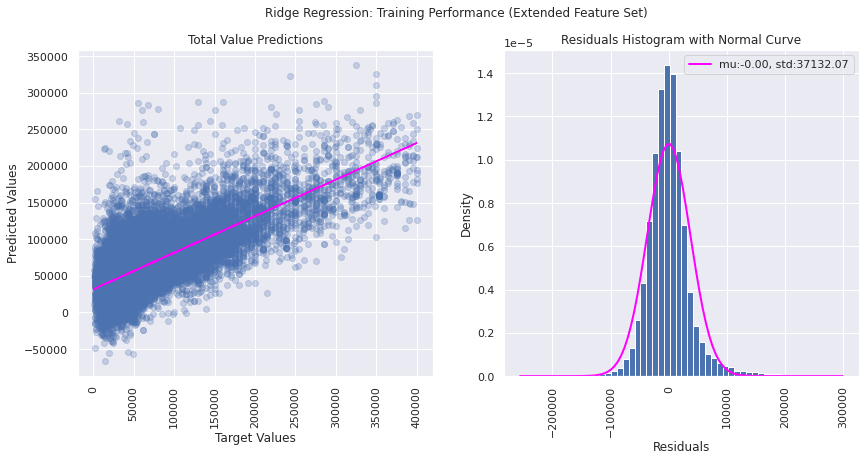

In [68]:
# create visualizations to evaluate performance
getPredictionPlot(train_y, y_pred_train, "Ridge Regression: Training Performance (Extended Feature Set)")

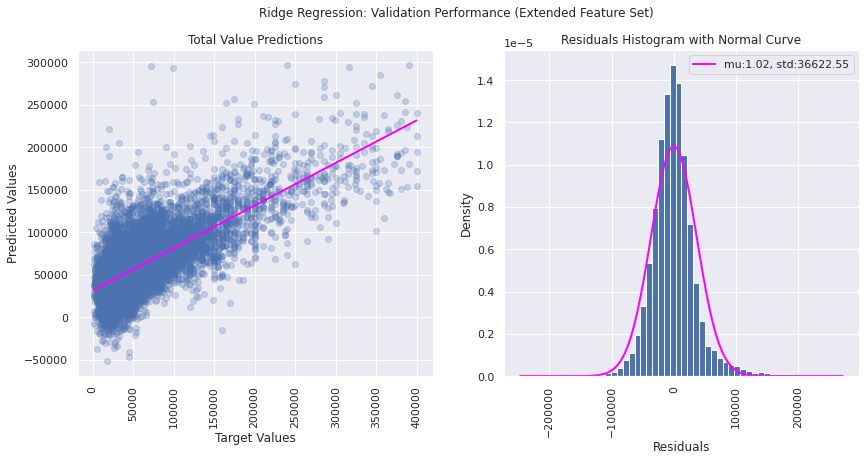

In [69]:
# create visualizations to evaluate performance
getPredictionPlot(val_y, y_pred_validation, "Ridge Regression: Validation Performance (Extended Feature Set)")

## Huber: Linear regression model that is robust to outliers.

Using same numeric features as previous models

In [70]:
# define the model
LRmodel = HuberRegressor()
# define the data that will be used in the model
regression_cols = ["Property Class Description", "Front", "Age",
                   "Total Living Area", "# of Fireplaces", 
                   "# of Beds", "TotalBaths"]
                   
# save and fit the pipeline
HuberPipeline, train_x, train_y, train_time = fitLRModelPipeline(LRmodel, df, regression_cols)

HuberRegressor() training time: 0.7765929698944092
Coefficients: 
 [ 18413.09954944 -15944.14721558    366.79702613   -412.32786202
     43.30165894  23935.78973547  -6361.17968756  14567.78573122]
Intercept: 
 2469.8282840538886


In [71]:
# save predictions from data
val_x = val_df[regression_cols]
val_y = val_df["Total Value"]


y_pred_train = HuberPipeline.predict(train_x)
y_pred_validation = HuberPipeline.predict(val_x)

# update the results and evaluate performance of predictions on target
results_df = getRegressionMetrics(train_y, y_pred_train, results_df, "Huber", regression_cols, train_time, "Train")
results_df = getRegressionMetrics(val_y, y_pred_validation, results_df, "Huber", regression_cols, train_time, "Validation") 

Mean squared error: 1295085479.73
Root Mean squared error: 35987.30
Mean absolute error: 24339.75
Median absolute error: 16919.93
Coefficient of determination: 0.53

Sample of 10 predictions vs. target:
Predicted values:  [ 88683.  75501.  45816.  95033.  86320.  32854.  23531. 117021.  52419.
  52643.]
Target values:  SBL
1003800004027000    175000.0
0907200002032000     10000.0
0896700003003000     33800.0
0797100006030000     51100.0
1334800003004000     75000.0
0887400003012000     35500.0
1016900005054111     25000.0
0788400002006000    295000.0
0907900002024000     25000.0
0887400003019000     35000.0
Name: Total Value, dtype: float64
Mean squared error: 1248685389.52
Root Mean squared error: 35336.74
Mean absolute error: 23949.30
Median absolute error: 16491.82
Coefficient of determination: 0.53

Sample of 10 predictions vs. target:
Predicted values:  [ 54065.  14896.  65054.  70821.  30451.  47076.  92875. 103075.  98794.
  25963.]
Target values:  SBL
1334600001006000        65

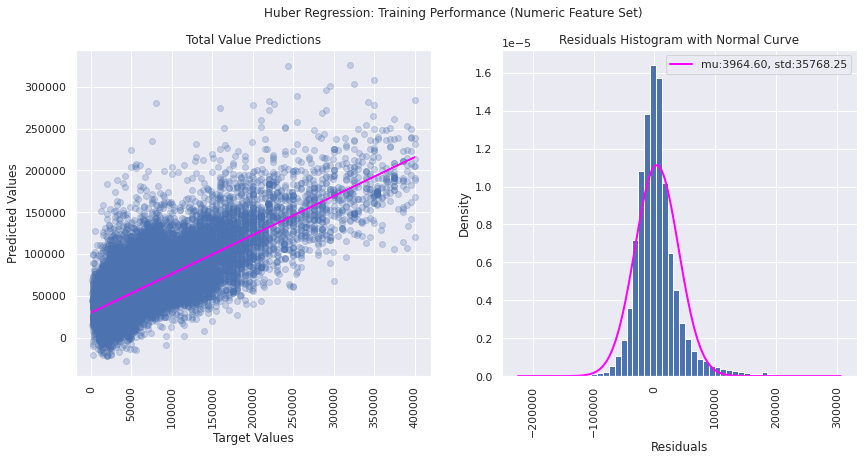

In [72]:
# create visualizations to evaluate performance
getPredictionPlot(train_y, y_pred_train, "Huber Regression: Training Performance (Numeric Feature Set)")

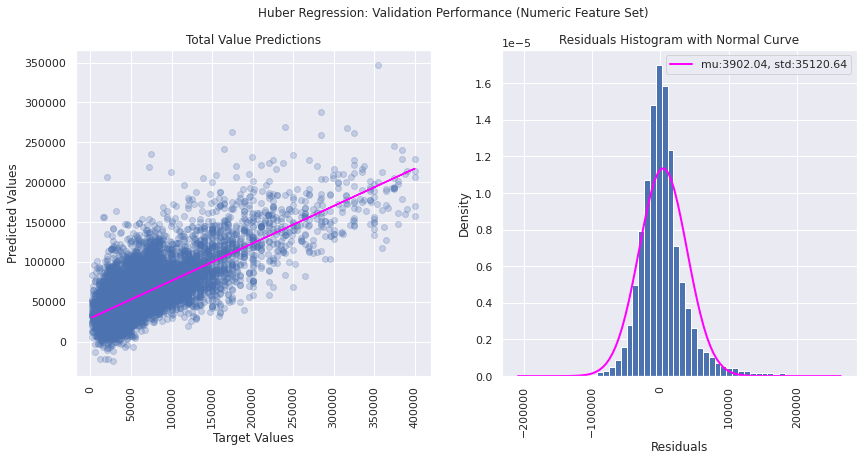

In [73]:
# create visualizations to evaluate performance
getPredictionPlot(val_y, y_pred_validation, "Huber Regression: Validation Performance (Numeric Feature Set)")

Adding Neighborhood

In [74]:
# define the model
LRmodel = HuberRegressor()
# define the data that will be used in the model
regression_cols = ["Property Class Description", "Neighborhood", "Front", "Age",
                   "Total Living Area", "# of Fireplaces", "# of Beds", 
                   "TotalBaths"]
# save and fit the pipeline
HuberPipeline, train_x, train_y, train_time = fitLRModelPipeline(LRmodel, df, regression_cols)

HuberRegressor() training time: 0.936215877532959
Coefficients: 
 [ 19386.93897648 -16253.27941264   1268.10950455  -1704.10873012
 -11835.84511402   1462.14657549   6662.92370966  -5725.54052365
  -1395.26045663   9308.47945967   3370.29324147  -5589.13219293
  -2062.44234347  -2530.17257416  -8702.61210347   -665.54361201
  -4400.96031243    -64.95004017   3077.04264301  -2223.12360165
  -2032.52681175   -417.17658423   -158.34862067  -4452.07185689
  -8377.1658718   21817.96412207   9464.43535126  -1722.826494
   2586.96099641  -3057.26698369  -1954.86972567    605.91053797
  15141.90071202     89.09120811   2037.08585835  -3159.79785796
    741.24190386  -2268.18385063    298.17453652   -409.45478306
     26.86191367  22161.79780598   1096.6770688   15041.67459378]
Intercept: 
 3134.116675527781


In [75]:
# save predictions from data
val_x = val_df[regression_cols]
val_y = val_df["Total Value"]


y_pred_train = HuberPipeline.predict(train_x)
y_pred_validation = HuberPipeline.predict(val_x)

# update the results and evaluate performance of predictions on target
results_df = getRegressionMetrics(train_y, y_pred_train, results_df, "Huber", regression_cols, train_time, "Train")
results_df = getRegressionMetrics(val_y, y_pred_validation, results_df, "Huber", regression_cols, train_time, "Validation") 

Mean squared error: 1140657302.98
Root Mean squared error: 33773.62
Mean absolute error: 20649.62
Median absolute error: 12804.76
Coefficient of determination: 0.59

Sample of 10 predictions vs. target:
Predicted values:  [ 80952.  83198.  45558.  95388.  81497.  46728.  20999. 104665.  47304.
  53386.]
Target values:  SBL
1003800004027000    175000.0
0907200002032000     10000.0
0896700003003000     33800.0
0797100006030000     51100.0
1334800003004000     75000.0
0887400003012000     35500.0
1016900005054111     25000.0
0788400002006000    295000.0
0907900002024000     25000.0
0887400003019000     35000.0
Name: Total Value, dtype: float64
Mean squared error: 1093356826.73
Root Mean squared error: 33065.95
Mean absolute error: 20215.89
Median absolute error: 12470.67
Coefficient of determination: 0.59

Sample of 10 predictions vs. target:
Predicted values:  [57717. -6015. 84138. 72953. 35552. 51382. 81565. 98180. 85057. 22379.]
Target values:  SBL
1334600001006000        65000.0
10076

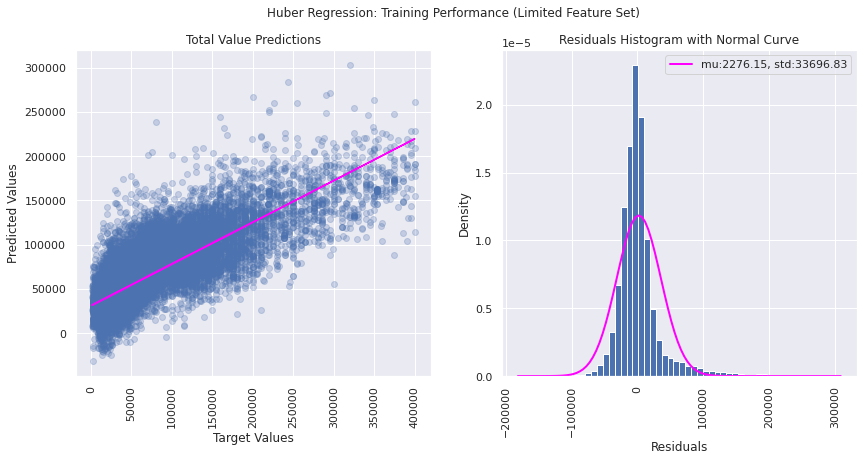

In [76]:
# create visualizations to evaluate performance
getPredictionPlot(train_y, y_pred_train, "Huber Regression: Training Performance (Limited Feature Set)")

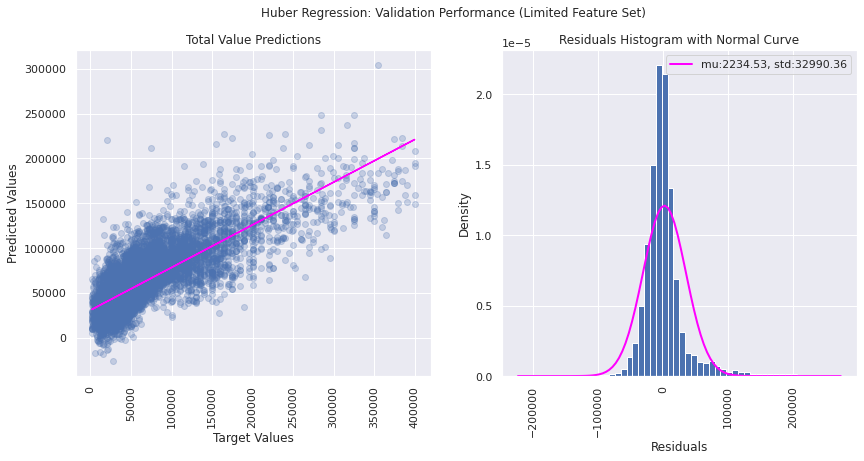

In [77]:
# create visualizations to evaluate performance
getPredictionPlot(val_y, y_pred_validation, "Huber Regression: Validation Performance (Limited Feature Set)")

Adding more categorical columns

In [78]:
# define the model
LRmodel = HuberRegressor()
# define the data that will be used in the model
regression_cols = ["Property Class Description", "Neighborhood", "Front", "Age",
                   "Total Living Area", "# of Fireplaces", "# of Beds", 
                   "TotalBaths", "Overall Condition", "Building Style", 
                   "Heat Type"]
# save and fit the pipeline
HuberPipeline, train_x, train_y, train_time = fitLRModelPipeline(LRmodel, df, regression_cols)

HuberRegressor() training time: 1.242917537689209
Coefficients: 
 [ 1.83379318e+04 -1.63174123e+04  1.87735848e+03 -2.22143199e+03
 -1.48149419e+04  2.12089514e+03  9.41607760e+03 -8.01317526e+03
 -1.86383732e+03  1.30232583e+04  4.88054926e+03 -7.99816372e+03
 -2.70979196e+03 -3.48499773e+03 -1.16860883e+04 -7.58996005e+02
 -6.22601082e+03 -2.31709023e+02  4.34482180e+03 -3.13302824e+03
 -3.64340689e+03 -3.74497356e+02 -1.08187041e+02 -6.32044154e+03
 -1.15150243e+04  2.94111953e+04  1.34832862e+04 -2.53361759e+03
  2.66715729e+03 -4.45494735e+03 -2.45336644e+03  7.15350918e+02
  1.85503716e+04  1.28950775e+02  2.25472410e+03 -4.19570216e+03
  9.12967005e+02 -3.02508150e+03 -2.23712280e+03 -7.59497141e+03
  6.89584579e+03  4.92742314e+03  2.93447190e+01  1.05438701e+03
 -1.84895397e+02  1.05939072e+02  1.53459317e+03 -1.27183150e+03
  9.17563046e+01  1.43278639e+01 -1.92635168e+03 -1.07326182e+02
 -1.80891944e+01 -4.97377077e+02 -1.18357883e+02  7.37813216e+01
  9.18038235e+02  2.4643

In [79]:
# save predictions from data
val_x = val_df[regression_cols]
val_y = val_df["Total Value"]


y_pred_train = HuberPipeline.predict(train_x)
y_pred_validation = HuberPipeline.predict(val_x)

# update the results and evaluate performance of predictions on target
results_df = getRegressionMetrics(train_y, y_pred_train, results_df, "Huber", regression_cols, train_time, "Train")
results_df = getRegressionMetrics(val_y, y_pred_validation, results_df, "Huber", regression_cols, train_time, "Validation") 

Mean squared error: 975475127.25
Root Mean squared error: 31232.60
Mean absolute error: 19186.38
Median absolute error: 11696.04
Coefficient of determination: 0.65

Sample of 10 predictions vs. target:
Predicted values:  [ 95506.  60360.  39223.  85704.  92591.  33306.  14681. 119109.  40221.
  55917.]
Target values:  SBL
1003800004027000    175000.0
0907200002032000     10000.0
0896700003003000     33800.0
0797100006030000     51100.0
1334800003004000     75000.0
0887400003012000     35500.0
1016900005054111     25000.0
0788400002006000    295000.0
0907900002024000     25000.0
0887400003019000     35000.0
Name: Total Value, dtype: float64
Mean squared error: 937868382.80
Root Mean squared error: 30624.64
Mean absolute error: 18842.77
Median absolute error: 11583.19
Coefficient of determination: 0.65

Sample of 10 predictions vs. target:
Predicted values:  [49543. -6408. 87448. 85486. 34112. 40460. 71415. 85134. 71568. 27637.]
Target values:  SBL
1334600001006000        65000.0
1007600

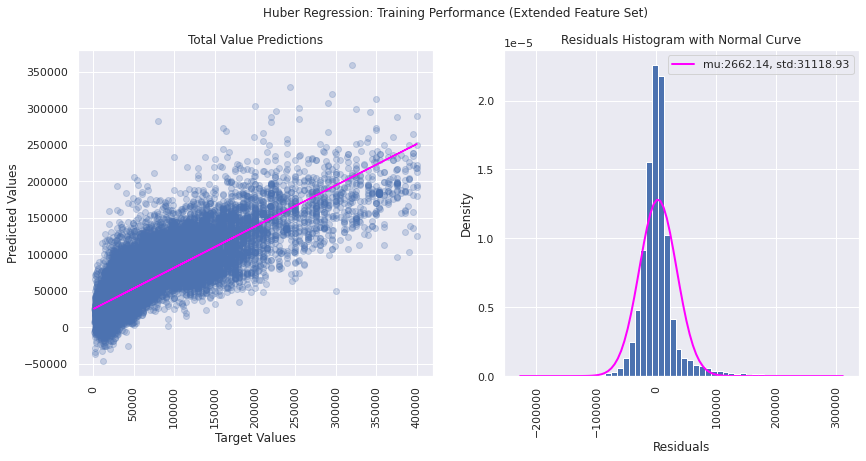

In [80]:
# create visualizations to evaluate performance
getPredictionPlot(train_y, y_pred_train, "Huber Regression: Training Performance (Extended Feature Set)")

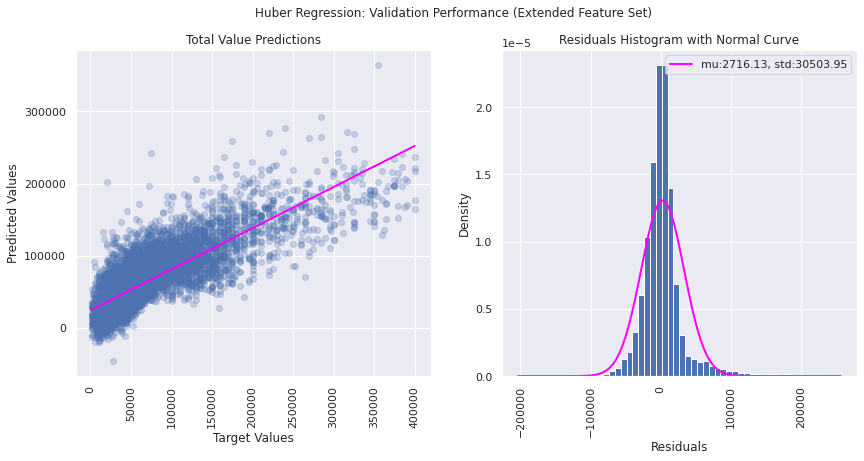

In [81]:
# create visualizations to evaluate performance
getPredictionPlot(val_y, y_pred_validation, "Huber Regression: Validation Performance (Extended Feature Set)")

## Summary of Results

In [82]:
results_df

,Model,Features,MSE,RMSE,Mean Abs. Error,Median Abs. Error,R2 Score,Train Time,Test Partition
0,OLS,"[Property Class Description, Front, Age, Total...",1.229771e+09,35068.10,24645.21,17785.11,0.55,0.054192,Train
1,OLS,"[Property Class Description, Front, Age, Total...",1.182015e+09,34380.45,24239.62,17169.03,0.56,0.054192,Validation
2,OLS,"[Property Class Description, Neighborhood, Fro...",6.642341e+08,25772.74,16065.81,10006.15,0.76,0.211069,Train
3,OLS,"[Property Class Description, Neighborhood, Fro...",6.344077e+08,25187.45,15808.76,9991.01,0.76,0.211069,Validation
4,OLS,"[Property Class Description, Neighborhood, Fro...",6.492099e+08,25479.60,15852.44,9879.76,0.76,0.460827,Train
5,OLS,"[Property Class Description, Neighborhood, Fro...",6.220239e+08,24940.41,15621.75,9861.52,0.77,0.460827,Validation
6,Lasso,"[Property Class Description, Front, Age, Total...",1.229771e+09,35068.10,24645.03,17782.10,0.55,0.037690,Train
7,Lasso,"[Property Class Description, Front, Age, Total...",1.182017e+09,34380.48,24239.41,17171.25,0.56,0.037690,Validation
8,Lasso,"[Property Class Description, Neighborhood, Fro...",6.642404e+08,25772.86,16065.60,10008.44,0.76,5.776232,Train
9,Lasso,"[Property Class Description, Neighborhood, Fro...",6.344137e+08,25187.57,15808.92,9990.12,0.76,5.776232,Validation


In [83]:
results_df.to_csv("/content/drive/MyDrive/ML/ML-Project/data/results/LinearRegressionResults.csv")